In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import relabel_sequential
from tifffile import imread
from stardist.matching import matching, matching_dataset, group_matching_labels
from tqdm import tqdm
from skimage.segmentation import relabel_sequential
import statistics
import surface_distance

import sys
import os
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[2])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, get_tensorboard_logs
from src.visualization.visualize import plot_matching_dataset_results, plot_confusion_matrix
from src.data.preprocess_utils import load_files, resample_crop_downsample
from src.models.stardist3D import stardist_predict, threshold_optimization
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object
import seaborn as sns

sns.set(font_scale=1.2)
sns.set_palette("Set2")

## Experiment´s directories

In [47]:
exp_dir = os.path.join(module_path, "experiments", "exp02")
os.listdir(os.path.join(exp_dir, "results"))   # results are on a hard drive
Path(os.path.join(module_path, "reports", "figures", "vollseg")).mkdir(parents=True, exist_ok=True)   # create dir to save figures

['.gitkeep',
 'BinaryMask',
 'BinaryMask - ShortCut.lnk',
 'regions',
 'regions - Shortcut.lnk',
 'unet_pred',
 'unet_pred - Shortcut.lnk']

## Load predictions

In [53]:
predictions = load_files(os.path.join(exp_dir, "results", "BinaryMask"))   # predictions of the time-lapse are already matched in consecutive frames
predictions[0].shape

Loading files with step size: 1 from D:\Alf_Honigmann_mESC_LightSheet\organoid-segmentation-ML\experiments\exp02\results\BinaryMask\matched


(288, 288, 288)

In [ ]:
binary = load_files(os.path.join(exp_dir, "results", "regions"))
binary[0].shape

In [ ]:
unet_pred = load_files(os.path.join(exp_dir, "results", "unet_pred"))
unet_pred[0].shape

In [54]:
# raw = load_files(os.path.join(module_path, "data", "stardist_train_val_test_2022-08-17", "test", "raw_normalized"))
y_true, fnames = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"), return_fnames=True)

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\isotropic


## Visualize in napari

In [ ]:
import napari

In [ ]:
viewer = napari.Viewer()

# add original raw data
viewer.add_image(np.array(raw))

# add predicted labels
viewer.add_labels((np.array(predictions)).astype('int32'), name="final_predictions")
viewer.add_image((np.array(unet_pred)).astype('float32'), name="unet_pred")
viewer.add_labels((np.array(binary)).astype('int32'), name="binary")

## Metrics

In [59]:
def evaluate_single_thresh_metrics_per_frame(true, pred):
    metrics = [matching(np.array(i).astype('int32'), np.array(j).astype('int32'), thresh=0.3, criterion='iou', report_matches=False) for i, j in tqdm(zip(true, pred), total=len(y_true))]
    return metrics

In [60]:
metrics = evaluate_single_thresh_metrics_per_frame(y_true, predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:38<00:00,  1.10s/it]


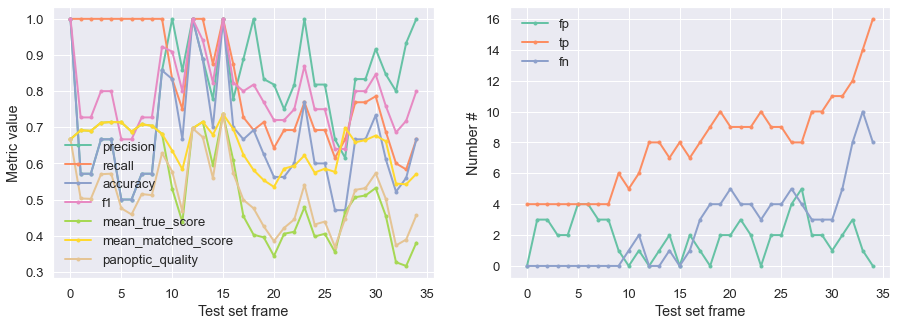

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m, fname in zip(('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'), fnames):
    ax1.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics]], '.-', lw=2, label=m)
ax1.set_xlabel(r'Test set frame')
ax1.set_ylabel('Metric value')
ax1.legend(frameon=False)

for m in ('fp', 'tp', 'fn'):
    ax2.plot([i for i, f in enumerate(fnames)], [t for t in [s._asdict()[m] for s in metrics]], '.-', lw=2, label=m)
ax2.set_xlabel(r'Test set frame')
ax2.set_ylabel('Number #')
ax2.legend(frameon=False)

### Compute metrics for multiple thresholds

In [77]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [78]:
metrics_multi_thres = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:18<00:00, 42.05s/it]


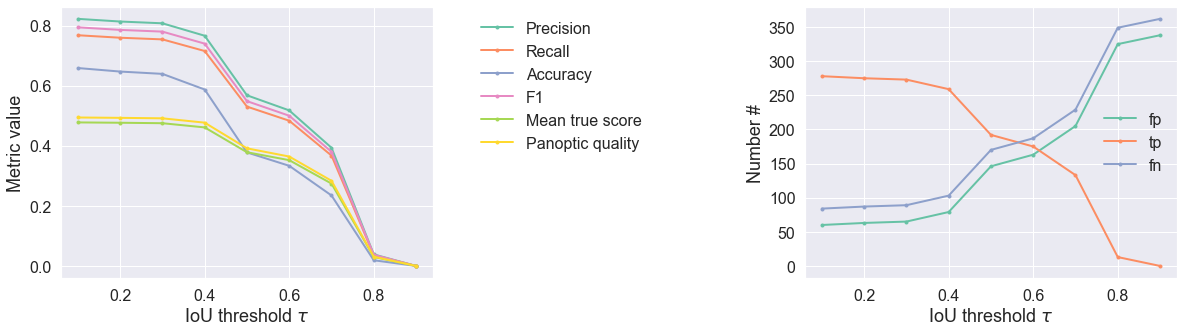

In [79]:
plot_matching_dataset_results(metrics_multi_thres, taus, save_dir=os.path.join(module_path, "reports", "figures", "vollseg", "exp02_vollseg_multithres.png"))

In [63]:
metrics = matching_dataset(np.array(y_true).astype("int32"), np.array(predictions).astype("int32"), thresh=0.3, show_progress=False)

In [65]:
metrics

DatasetMatching(criterion='iou', thresh=0.3, fp=65, tp=273, fn=89, precision=0.8076923076923077, recall=0.7541436464088398, accuracy=0.639344262295082, f1=0.78, n_true=362, n_pred=338, mean_true_score=0.47510942701476716, mean_matched_score=0.6299985808767242, panoptic_quality=0.4913988930838449, by_image=False)

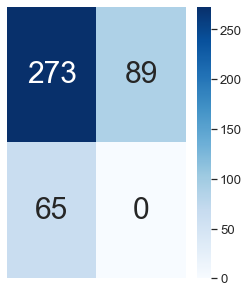

In [75]:
plot_confusion_matrix(metrics, save_dir = os.path.join(module_path, "reports", "figures", "vollseg", "exp02_vollseg_cm.png"))

## Boundary based metrics

In [38]:
res_df = get_boundary_based_metrics_per_object(predictions, y_true, spacing_mm = (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

Computing surface distances dict for each label: 100%|█████████████████████████████████| 35/35 [09:03<00:00, 15.53s/it]
metrics.py (319): invalid value encountered in double_scalars
metrics.py (317): invalid value encountered in double_scalars
metrics.py (391): invalid value encountered in double_scalars
metrics.py (388): invalid value encountered in double_scalars
metrics.py (421): invalid value encountered in double_scalars


In [39]:
pd.set_option('display.max_rows', res_df.shape[0]+1)
res_df_wo_nans= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])

In [40]:
final = res_df_wo_nans.reset_index(drop=True)
final

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
0,0.674638,3.278469,16.512213,0.302862,0.314791,0.309040,0.790216
1,0.588840,2.507550,9.116624,0.384057,0.334058,0.356360,0.810204
2,0.573259,0.968180,3.876127,0.464691,0.466517,0.465628,0.815294
3,0.601347,1.288581,4.008974,0.425949,0.365310,0.392991,0.784590
4,0.683661,3.871243,18.058416,0.318146,0.311184,0.314366,0.777799
5,0.621079,0.910204,3.447001,0.368034,0.444895,0.403469,0.826137
6,0.571902,0.907231,3.222633,0.474086,0.468159,0.470995,0.825202
7,0.553481,0.863298,3.345661,0.483390,0.508682,0.495963,0.839911
8,0.620506,3.160423,15.568078,0.382670,0.326055,0.350430,0.790727
9,0.637672,0.562235,1.038000,0.368441,0.490684,0.422874,0.825453


In [81]:
final.to_csv(r"exp02_distance_metrics_df.csv")

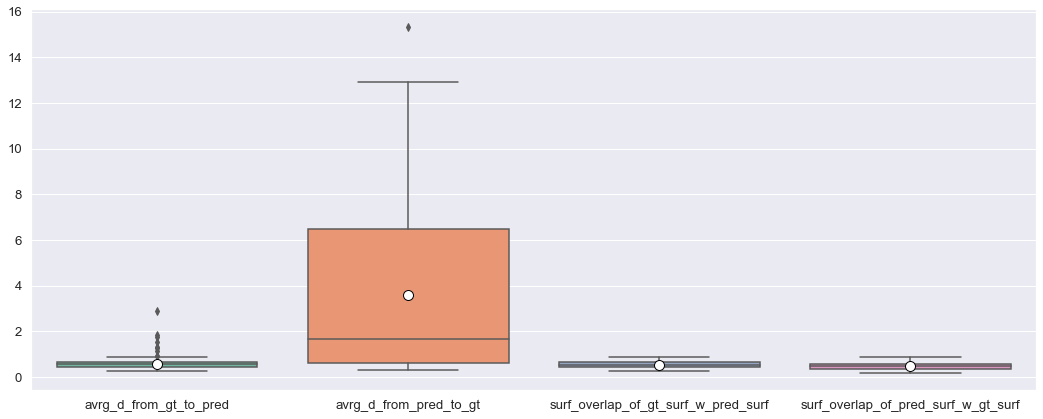

In [85]:
f, ax = plt.subplots(1, figsize = (18,7))

sns.boxplot(data=final[["avrg_d_from_gt_to_pred", "avrg_d_from_pred_to_gt", "surf_overlap_of_gt_surf_w_pred_surf", "surf_overlap_of_pred_surf_w_gt_surf"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                                                                                                                               "markerfacecolor":"white", 
                                                                                                                                                                                               "markeredgecolor":"black", "markersize":"10"})
plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp02_distance_metrics_boxplot.png"), bbox_inches='tight')

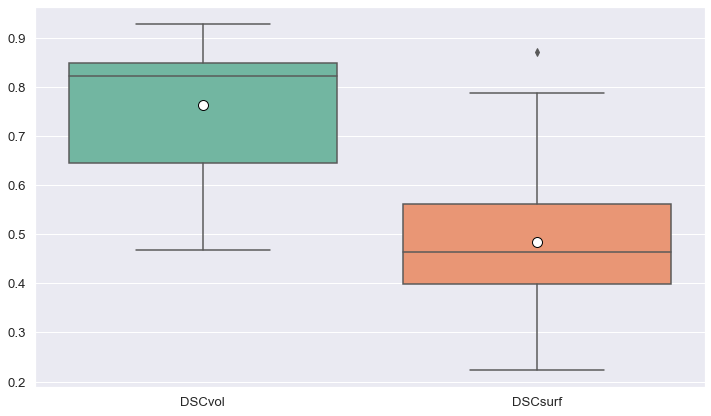

In [86]:
f, ax = plt.subplots(1, figsize = (12,7))

sns.boxplot(data=final[["DSCvol", "DSCsurf"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                  "markerfacecolor":"white", 
                                                                                  "markeredgecolor":"black",
                                                                                  "markersize":"10"})

plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp02_distance_metrics_boxplot_DSCvol_and_surf.png"), bbox_inches='tight')

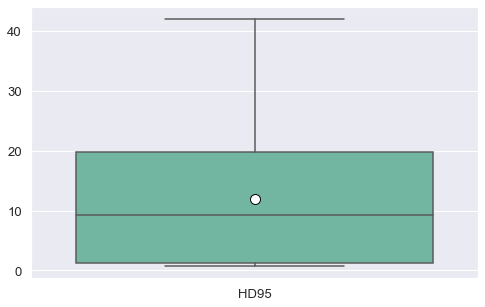

In [88]:
f, ax = plt.subplots(1, figsize = (8,5))

sns.boxplot(data=final[["HD95"]], showmeans=True, ax = ax,meanprops={"marker":"o",
                                                                                  "markerfacecolor":"white", 
                                                                                  "markeredgecolor":"black",
                                                                                  "markersize":"10"})

plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp02_distance_metrics_HD95.png"), bbox_inches='tight')

In [82]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.572319907934953,
 'Mean distance from predicted to the GT surface in microns': 3.5939843206333837,
 'Mean Hausdorff95 distance': 11.869508577844016,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.5264496296330501,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.4697532125141968,
 'Mean surface DSC': 0.483189335950833,
 'Mean volume DSC over matched objects': 0.7631120491721458,
 'tp': 273,
 'fn': 89,
 'fp': 65,
 'precision': 0.8076923076923077,
 'recall': 0.7541436464088398,
 'accuracy': 0.639344262295082,
 'f1': 0.78,
 'mean_true_score': 0.47510942701476716,
 'mean_matched_score': 0.6299985808767242,
 'panoptic_quality': 0.4913988930838449}

In [83]:
import json

with open("exp02_metrics.json", "w") as f:
    json.dump(metrics_combined, f) 